# Whole brain data processing

In [172]:
import numpy as np
import pandas as pd
import os, sys
from glob import glob
from h5py import File
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import dask.array as da
from utils import *
import time
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up environments

In [2]:
dir_root = '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20161109/fish2/20161109_2_1_6dpf_GFAP_GC_Huc_RG_GA_CL_fb_OL_f0_0GAIN_20161109_211950/raw'
save_dir = ''
cameraNoiseMat = '/groups/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208'
numCores = 60

In [3]:
import fish_proc.utils.dask_ as fdask
cluster, client = fdask.setup_workers(numCores)
client

Client Scheduler: tcp://10.36.111.11:44799 Dashboard: http://10.36.111.11:8787/status,Cluster Workers: 4 Cores: 4 Memory: 64.00 GB


## Load file to dask

In [4]:
files = sorted(glob(dir_root+'/*.h5'))
chunks = File(files[0],'r')['default'].shape
files = files[::10] # this is for test purpose
data = da.stack([da.from_array(File(fn,'r')['default'], chunks=chunks) for fn in files])

## Pixel denoise
* Test of comparison -- see notebook test_data_compression

In [5]:
from fish_proc.utils.getCameraInfo import getCameraInfo
cameraInfo = getCameraInfo(dir_root)
denoised_data = data.map_blocks(lambda v: pixelDenoiseImag(v, cameraInfo=cameraInfo), dtype='float32')

In [6]:
if not os.path.exists('motion_fix_.h5'):
    med_win = len(denoised_data)
    ref_img = denoised_data[med_win-100:med_win+100].mean(axis=0).compute()
    save_h5('motion_fix_.h5', ref_img, dtype='float16')
else:
    ref_img = File('motion_fix_.h5', 'r')['default'].value

In [7]:
ref_img = ref_img.max(axis=0, keepdims=True)

## Registration

In [8]:
%%time
if not os.path.exists('trans_affs.npy'):
    trans_affine = denoised_data.map_blocks(lambda x: estimate_rigid2d(x, fixed=ref_img), dtype='float32', drop_axis=(3), chunks=(1,4,4)).compute()
    np.save('trans_affs', trans_affine)

CPU times: user 0 ns, sys: 26 µs, total: 26 µs
Wall time: 29.8 µs


In [9]:
trans_affine_ = np.load('trans_affs.npy')
trans_affine_ = da.from_array(trans_affine_, chunks=(1,4,4))

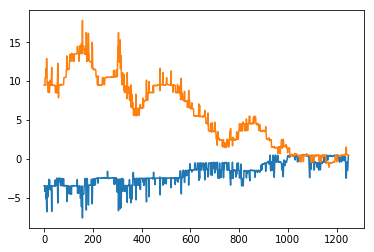

In [10]:
plt.plot(trans_affine_[:, 1, -1])
plt.plot(trans_affine_[:, 2, -1])
plt.show()

### Compute registered images
* z, x, y, t -- `trans_data_t` will be used for df/f computation after spatal component matrix is obtained

In [11]:
denoised_data = denoised_data[:250, 12:14]
trans_affine_ = trans_affine_[:250]

In [12]:
trans_data_ = da.map_blocks(apply_transform3d, denoised_data, trans_affine_, chunks=(1, *denoised_data.shape[1:]), dtype='float32')
chunk_x, chunk_y = chunks[-2:]
trans_data_t = trans_data_.transpose((1, 2, 3, 0)).rechunk((1, chunk_x//4, chunk_y//4, -1))

In [13]:
trans_data_t

dask.array<rechunk-merge, shape=(2, 2048, 2048, 250), dtype=float32, chunksize=(1, 512, 512, 250)>

## Video Detrend
* use more trackable video detrend algorithm -- for example running percentile instead of local fit -- this will saving space in trend data

In [14]:
baseline_t = trans_data_t.map_blocks(lambda v: baseline(v, window=100, percentile=20), dtype='float32')
Y_d = trans_data_t.map_blocks(lambda v: v - baseline(v, window=100, percentile=20), dtype='float32')

In [348]:
Y_d = trans_data_t.map_blocks(lambda v: v - baseline(v, window=100, percentile=20), dtype='float32')

In [350]:
numCores = 20
cluster.start_workers(numCores)
Y_d.to_zarr('detrend_data.zarr')

### test data

In [15]:
test_video_detrend = False
if test_video_detrend:
    test_ = trans_data_t[12, 256, 256, :].compute()
    cluster.stop_all_jobs()
    time.sleep(10)

    cluster.start_workers(numCores)
    test_baseline = baseline_t[12, 256, 256, :].compute()
    cluster.stop_all_jobs()
    time.sleep(10)

    cluster.start_workers(numCores)
    test_d = Y_d[12, 256, 256, :].compute()
    cluster.stop_all_jobs()
    time.sleep(10)
    
    plt.plot(test_)
    plt.plot(test_baseline)
    plt.title('F and basline')
    plt.show()
    min_ = np.min(np.percentile(test_, 0.3), 0)
    dff = test_d/(test_baseline-min_)
    plt.plot(dff)
    plt.title('df/f')
    plt.show()

## Local PCA
* This data should be saved as the sparse matrices

In [16]:
if not os.path.exists(f'{save_dir}Y_2dnorm_ave.h5'):
    numCores = 120
    cluster.start_workers(numCores)
    Y_d_ave = Y_d.mean(axis=-1, keepdims=True, dtype='float32').compute()
    save_h5(f'{save_dir}Y_2dnorm_ave.h5', Y_d_ave, dtype='float32')
    cluster.stop_all_jobs()
    time.sleep(10)

In [18]:
Y_d_ave_ = da.from_array(File(f'{save_dir}Y_2dnorm_ave.h5', 'r')['default'], chunks=(1, chunk_x//4, chunk_y//4, -1))
Y_d_std_ = da.from_array(File(f'{save_dir}Y_2dnorm_std.h5', 'r')['default'], chunks=(1, chunk_x//4, chunk_y//4, -1))

In [19]:
Y_d_ave_ = Y_d_ave_[12:14]

In [21]:
Y_d = Y_d - Y_d_ave_
xy_lap = 10 # overlap by 10 pixel in blocks
g = da.overlap.overlap(Y_d, depth={1: xy_lap, 2: xy_lap}, boundary={1: 0, 2: 0})

In [68]:
numCores = 20
cluster.start_workers(numCores)
# this is a test for middle layers
Y_svd = g.map_blocks(local_pca, dtype='float32')
Y_svd = da.overlap.trim_internal(Y_svd, {1: xy_lap, 2: xy_lap})
if os.path.exists('local_pca_data.zarr'):
    shutil.rmtree('local_pca_data.zarr')
Y_svd.to_zarr('local_pca_data.zarr')

In [430]:
try:
    cluster.stop_all_jobs()
    time.sleep(10)
except:
    pass

## Mask
Making a mask for data to decrease the number of computation in demix
* remove low intensity pixel
* remove low snr pixel
* remove low local pixel correlation pixels

### Create intensity mask

In [395]:
save_root = '.'

In [396]:
Y_d_ave_ = da.from_array(File(f'{save_dir}Y_2dnorm_ave.h5', 'r')['default'], chunks=(1, -1, -1, -1))

In [397]:
def intesity_mask(blocks, percentile=40):
    return blocks>np.percentile(blocks, percentile)

In [398]:
numCores = mask_ave_.shape[0]
cluster.start_workers(numCores)
mask_ave_ =  Y_d_ave_.map_blocks(intesity_mask).compute()
try:
    cluster.stop_all_jobs()
    time.sleep(10)
except:
    pass

In [400]:
mask_ave_ = mask_ave_[12:14]

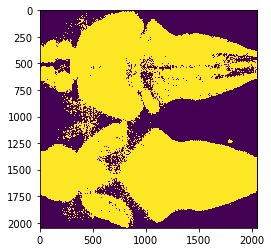

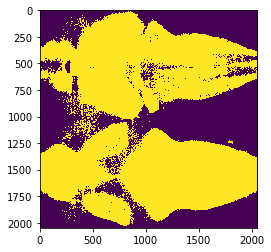

In [401]:
# check intensity mask
for n_ave_ in mask_ave_.squeeze():
    plt.imshow(n_ave_)
    plt.show()

## create snr map

In [403]:
Y_svd_ = da.from_zarr(f'{save_root}/local_pca_data.zarr')
Y_svd_ = Y_svd_.rechunk((1, -1, -1, -1))

In [417]:
from fish_proc.utils.snr import correlation_pnr
from fish_proc.utils.noise_estimator import get_noise_fft

In [451]:
def snr_mask(Y_svd, std_per=20, snr_per=10):    
    Y_svd = Y_svd.squeeze()
    d1, d2, _ = Y_svd.shape
    mean_ = Y_svd.mean(axis=-1,keepdims=True)
    sn, _ = get_noise_fft(Y_svd - mean_,noise_method='logmexp')
    SNR_ = Y_svd.var(axis=-1)/sn**2    
    Y_d_std = Y_svd.std(axis=-1)
    std_thres = np.percentile(Y_d_std.ravel(), std_per)
    mask = Y_d_std<=std_thres
    snr_thres = np.percentile(np.log(SNR_).ravel(), snr_per)
    mask = np.logical_or(mask, np.log(SNR_)<snr_thres)
    return mask.squeeze()

In [452]:
numCores = 20
cluster.start_workers(numCores)
is_skip_snr = True
mask_snr = mask_ave_.copy().squeeze(axis=-1) #drop last dim
Cn_list = np.zeros(mask_ave_.shape).squeeze(axis=-1) #drop last dim
for ii in range(Y_svd_.shape[0]):
    _ = Y_svd_[ii].compute().copy()
    _[~mask_ave_[ii].squeeze()] = 0
    if not is_skip_snr:
        mask_snr_ = snr_mask(_)
        _[mask_snr_] = 0
        mask_snr[ii] = np.logical_not(mask_snr_)
    Cn, _ = correlation_pnr(_, skip_pnr=True)
    Cn_list[ii] = Cn
try:
    cluster.stop_all_jobs()
    time.sleep(10)
except:
    pass

Number of processes to parallel: 32
Number of processes to parallel: 32


In [472]:
mask = mask_ave_ & np.expand_dims(mask_snr, -1)

In [470]:
save_h5()

(2, 2048, 2048, 1)

## create local correlation map

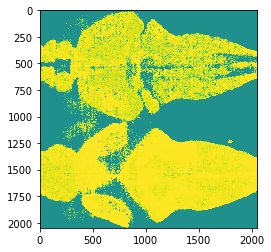

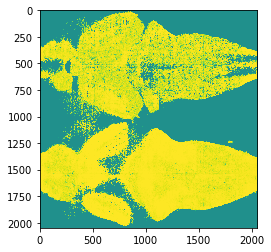

In [458]:
# check Cn mask
for n_ave_ in Cn_list:
    plt.imshow(n_ave_, vmin=-1, vmax=1)
    plt.show()

In [467]:
np.percentile(n_ave_, [90, 80, 60, 50])

array([0.99401685, 0.98029479, 0.92261738, 0.82346271])

## Demix
* down-sample in time

In [76]:
save_root = '.'
Y_svd_ = da.from_zarr(f'{save_root}/local_pca_data.zarr')
dt = 1
mov = Y_svd_[:, :, :, ::dt]
mov = mov.rechunk((1, -1, -1, -1))

In [80]:
from fish_proc.demix import superpixel_analysis as sup
import pickle

In [81]:
block = mov_test

In [140]:
Y_svd=block.copy().squeeze()
d1, d2, _ = Y_svd.shape
mean_ = Y_svd.mean(axis=-1,keepdims=True)
sn, _ = get_noise_fft(Y_svd - mean_,noise_method='logmexp')
SNR_ = Y_svd.var(axis=-1)/sn**2

In [ ]:
def demix_middle_data_with_mask(block, save_folder='.', block_id=None):
    from fish_proc.demix import superpixel_analysis as sup
    import pickle
    
    Y_svd=block.squeeze().copy()
    d1, d2, _ = Y_svd.shape
    mean_ = Y_svd.mean(axis=-1,keepdims=True)
    sn, _ = get_noise_fft(Y_svd - mean_,noise_method='logmexp')
    SNR_ = Y_svd.var(axis=-1)/sn**2
    std_thres = np.percentile(Y_d_std.ravel(), 20)
    mask = Y_d_std.squeeze(axis=-1)<=std_thres
    snr_thres = np.percentile(np.log(SNR_).ravel(), 10)
    mask = np.logical_or(mask, np.log(SNR_)<snr_thres)
    mask_out_region = np.logical_not(mask)
    mask_save = np.where(mask_out_region)
    np.savez(f'{save_folder}/mask_block_{block_id}', mask=mask, mask_save=mask_save)

    Y_svd[mask]=0 
    Cn, _ = correlation_pnr(mov_, skip_pnr=True)

    is_demix = False
    pass_num = 4
    cut_off_point=np.percentile(Cn.ravel(), [99, 95, 85, 65])
    while not is_demix and pass_num>=0:
        try:
            rlt_= sup.demix_whole_data(mov_, cut_off_point[4-pass_num:], length_cut=[10,15,15,15],
                                       th=[1,1,1,1], pass_num=pass_num, residual_cut = [0.6,0.6,0.6,0.6],
                                       corr_th_fix=0.3, max_allow_neuron_size=0.05, merge_corr_thr=cut_off_point[-1],
                                       merge_overlap_thr=0.6, num_plane=1, patch_size=[40, 40], plot_en=False,
                                       TF=False, fudge_factor=1, text=False, bg=False, max_iter=60,
                                       max_iter_fin=100, update_after=20)
            is_demix = True
        except:
            print(f'fail at pass_num {pass_num}')
            is_demix = False
            pass_num -= 1

    with open(f'{save_folder}/period_Y_demix_block_{block_id}_rlt.pkl', 'wb') as f:
        pickle.dump(rlt_, f)

    return None